In [1]:
from time import time
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os


import errno
import shutil

In [2]:
def copy(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

In [3]:
src = '../input/'
dest = '../LFW/lfw_home'
copy(src,dest)

In [4]:


print(os.listdir('../input'))
print(os.listdir('../LFW/lfw_home'))

path = '../LFW/'

['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']
['pairs.txt', 'pairsDevTest.txt', 'lfw-funneled.tgz', 'pairsDevTrain.txt']


In [5]:

lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=200,  download_if_missing = False)



In [6]:
n_samples, h, w = lfw_dataset.images.shape

X = lfw_dataset.data
n_features = X.shape[1]


y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

In [7]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 766
n_features: 2914
n_classes: 2


In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [9]:


n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 574 faces
done in 0.269s


In [10]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Projecting the input data on the eigenfaces orthonormal basis
done in 0.022s


In [11]:

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 2.805s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [12]:


print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.006s
               precision    recall  f1-score   support

 Colin Powell       0.84      0.78      0.81        59
George W Bush       0.91      0.93      0.92       133

     accuracy                           0.89       192
    macro avg       0.87      0.86      0.86       192
 weighted avg       0.88      0.89      0.88       192

[[ 46  13]
 [  9 124]]


In [13]:

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

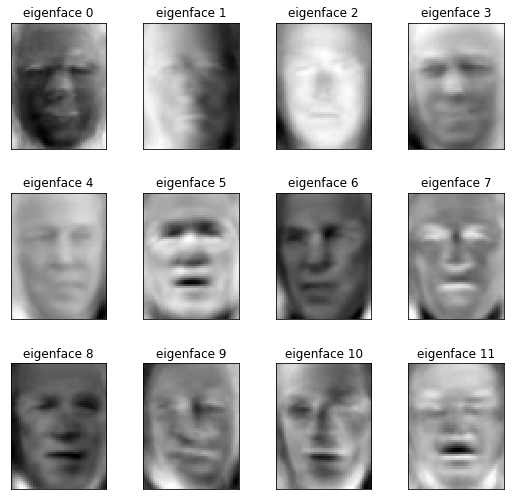

In [14]:


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

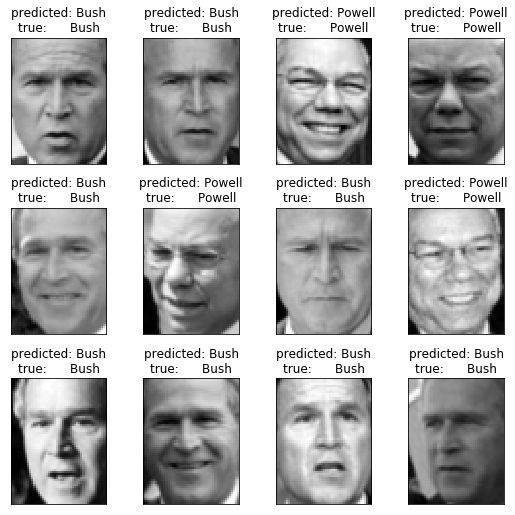

In [15]:


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)